In [1]:
# import os
# os.environ["TRITON_INTERPRET"] = "1"

In [5]:
import torch
from model_triton import *

#N, M, K = 16, 16, 16
#N, M, K = 4096, 4*768, 768 #FFN1
N, M, K = 4096, 768, 4*768 #FFN2
#N,M = 256, 256, #256, 128 #30, 27 #256, 128 #30, 27 #256, 128 #30, 27 #48, 48 #32, 32
#K = 256 #64 #16 #32 #16 #19
aa = torch.randn((N, K), device="cuda")
#aa = torch.arange(N*32, device="cuda").reshape(N,32).type(torch.float32)
bb = torch.randn((K, M), device="cuda")
#bb = torch.arange(32*M, device="cuda").reshape(32,M).type(torch.float32) + 1
N_RUNS = 10

#def t_softmax_fwd(x):
#    return torch.exp(t_log_softmax_fwd(x))
#fn_naive = t_log_softmax_fwd
#fn_naive = t_log_softmax_bkwd2
fn_naive = torch.matmul
fn_jit = torch.compile(fn_naive)
# burn it
#fn_jit(aa) 
#fn_jit(dloss_dx, aa) 
fn_jit(aa, bb) 

from torch.profiler import profile, record_function, ProfilerActivity, schedule
activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA]
with profile(activities=activities, record_shapes=True) as prof:
    for _ in range(N_RUNS):
        #result = fn_jit(aa)
        #result = fn_jit(dloss_dx, aa)
        result = fn_jit(aa, bb)
        
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

import time
t0 = time.time()
for _ in range(N_RUNS):
    #result = fn_jit(aa)
    #result = fn_jit(dloss_dx, aa)
    result = fn_jit(aa, bb)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'JIT total', total)

import time
t0 = time.time()
for _ in range(N_RUNS):
    #result = fn_naive(aa)
    #result = fn_naive(dloss_dx, aa)
    result = fn_naive(aa, bb)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'Naive total', total)

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Torch-Compiled Region: 0/0        24.51%       2.177ms        28.00%       2.487ms     248.664us       0.000us         0.00%       7.165ms     716.525us            10  
                                               aten::mm         2.48%     220.034us         3.49%     309.856us      30.986us       7.165ms       100.00%       7.165ms     716.525us            10  
void cutl

In [2]:
# import triton
# print(triton.runtime.driver.active.get_current_target())
# device = "cuda" #triton.runtime.driver.active.get_active_torch_device()
# properties = triton.runtime.driver.active.utils.get_device_properties(device)
# See https://github.com/triton-lang/triton/issues/5628, and https://github.com/triton-lang/triton/issues/5388
# properties

In [14]:
torch.backends.cuda.matmul.allow_tf32

True

In [6]:
import triton
import triton.language as tl

# This is an incomplete implementation. It makes the assumption that n_programs  
# and m_programs are disiable by GROUP_SIZE_M
# Assumes allow_tf32 (i.e. torch.backends.cuda.matmul.allow_tf32) being True 
# Note I overload this function by adding logic for linear layer in it
@triton.jit
def t_matmul_k(a_ptr, b_ptr, output_ptr, bias_ptr,
                a_row_stride, a_col_stride,
                b_row_stride, b_col_stride,
                output_row_stride, output_col_stride,
                n, m, k,
                ADD_BIAS: tl.constexpr, ACTIVATION: tl.constexpr, # Overloading matmul with params for linear layer
                BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
                GROUP_SIZE_M: tl.constexpr,
                ):
    # Matching PyTorch's fp32 dtype ( see https://github.com/triton-lang/triton/issues/4574)
    ASM: tl.constexpr = "cvt.rna.tf32.f32 $0, $1;"
        
    pid = tl.program_id(0)
    n_programs = tl.cdiv(n, BLOCK_SIZE_N)
    m_programs = tl.cdiv(m, BLOCK_SIZE_M)
    orig_n_pid = pid // m_programs
    orig_m_pid = pid % m_programs
       
    # TODO T: Fix bug in Grouping to improve L2 Cache hit rate
    # TODO T: simplify the grp_id calculations. Expand if m_programs are not divisable by GROUP_SIZE_M
    # m_groups = m_programs // GROUP_SIZE_M # assumes m_programs is divisable by GROUP_SIZE_M for now
    # n_grp_id = orig_n_pid % (n_programs//m_groups) # assumes n_programs is divisable by GROUP_SIZE_M for now
    # m_grp_id = (orig_n_pid * m_groups)//n_programs
    # n_pid =  n_grp_id * m_groups + orig_m_pid // GROUP_SIZE_M
    # m_pid =  m_grp_id * GROUP_SIZE_M + orig_m_pid % GROUP_SIZE_M
    n_pid = orig_n_pid
    m_pid = orig_m_pid 
    
    offsets = tl.arange(0, BLOCK_SIZE_K)     
    n_offsets = n_pid * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    m_offsets = m_pid * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    # TODO T: Do I need modulo n, modulo m operations?    
    n_offsets_mod = n_offsets %n
    m_offsets_mod = m_offsets %m
    
    acc = tl.zeros((BLOCK_SIZE_N, BLOCK_SIZE_M), dtype=tl.float32)
    for i in range(0, tl.cdiv(k, BLOCK_SIZE_K)):
        k_step_offsets = i*BLOCK_SIZE_K + offsets
        a_blck_ptr = a_ptr + n_offsets_mod[:,None] * a_row_stride + k_step_offsets[None, :] * a_col_stride
        a_blck = tl.load(a_blck_ptr, mask=k_step_offsets[None, :] < k, other=0.0) 
        b_blck_ptr = b_ptr + k_step_offsets[:,None] * b_row_stride + m_offsets_mod[None, :] * b_col_stride
        b_blck = tl.load(b_blck_ptr, mask=k_step_offsets[:, None] < k, other=0.0)

        # Matching PyTorch's fp32 dtype ( see https://github.com/triton-lang/triton/issues/4574)
        a_blck = tl.inline_asm_elementwise(ASM, "=r, r", [a_blck], dtype=tl.float32, is_pure=True, pack=1)
        b_blck = tl.inline_asm_elementwise(ASM, "=r, r", [b_blck], dtype=tl.float32, is_pure=True, pack=1)
        
        # To test for double precision (https://github.com/triton-lang/triton/issues/4603)
        # Use tf32x3 (slow) below without ASM elementwise casts above 
        acc = tl.dot(a_blck, b_blck, acc) #, input_precision="tf32x3")
    if ADD_BIAS:
        bias = tl.load(bias_ptr + m_offsets, mask=m_offsets<m, other=0.0)
        acc += bias # Works since Triton's broadcasting follows one of Numpy
    if ACTIVATION == "gelu":
        acc = gelu_k(acc)
    output_blck_ptr = output_ptr + n_offsets[:,None] * output_row_stride + m_offsets[None, :] * output_col_stride
    output_mask = (n_offsets[:,None] <n) & (m_offsets[None, :]<m)
    tl.store(output_blck_ptr, acc, mask=output_mask)
    
def t_matmul_t(a:torch.Tensor, b: torch.Tensor):
    N, K = a.shape
    K2, M = b.shape
    assert K==K2
    assert a.is_contiguous(), "Matrix A must be contiguous" # TODO T: why do I need contiguous a?
    output = torch.empty((N, M), device=a.device)
    grid = lambda META: (triton.cdiv(N, META['BLOCK_SIZE_N']) * triton.cdiv(M, META['BLOCK_SIZE_M']), )

    # One needs to tune params below depending on the size of input tensors 
    BLOCK_SIZE_N = 128    
    BLOCK_SIZE_M = 64
    BLOCK_SIZE_K = 32
    GROUP_SIZE_M = 8
    num_stages = 3
    num_warps = 8
    #assert triton.cdiv(N, BLOCK_SIZE_N) % GROUP_SIZE_M == 0, "Limtation of implementation" # TODO T: Complete implementation
    #assert triton.cdiv(M, BLOCK_SIZE_M) % GROUP_SIZE_M == 0, "Limtation of implementation" # TODO T: Complete implementation
    

    t_matmul_k[grid](
        a, b, output, None,
        a.stride(0), a.stride(1), b.stride(0), b.stride(1), output.stride(0), output.stride(1), 
        N, M, K, ADD_BIAS=False, ACTIVATION = None,
        BLOCK_SIZE_N=BLOCK_SIZE_N, BLOCK_SIZE_M=BLOCK_SIZE_M, BLOCK_SIZE_K=BLOCK_SIZE_K, 
        GROUP_SIZE_M=GROUP_SIZE_M, num_stages=num_stages, num_warps=num_warps)
    return output

fn_t = t_matmul_t

# from torch.profiler import profile, record_function, ProfilerActivity, schedule
# activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA]
# with profile(activities=activities, record_shapes=True) as prof:
#     for _ in range(N):
#         #result = fn_t(aa)
#         #result = fn_t(dloss_dx, aa)
#         result = fn_t(aa, bb)
# print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))

fn_t(aa, bb)

import time
t0 = time.time()
for _ in range(N_RUNS):
    #result = fn_t(aa)
    #result = fn_t(dloss_dx, aa)
    result = fn_t(aa, bb)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'total', total)

total 0.006819963455200195


In [5]:

allow_tf32_saved = torch.backends.cuda.matmul.allow_tf32
torch.backends.cuda.matmul.allow_tf32 = False
d_ref = torch.mm(aa.to(torch.double), bb.to(torch.double))
torch.backends.cuda.matmul.allow_tf32 = allow_tf32_saved
    

#res1 = fn_jit(aa)
#res1 = fn_jit(dloss_dx, aa)
res1 = fn_jit(aa, bb)
#res2 = fn_t(aa)
#res2 = fn_t(dloss_dx, aa)
res2 = fn_t(aa, bb)

print(f'd_ref', d_ref[:4, :4])
print(f'res1', res1[:4, :4])
print(f'res2', res2[:4, :4])
print(f'---')
print(f'd_ref', d_ref[-4:, -4:])
print(f'res1', res1[-4:, -4:])
print(f'res2', res2[-4:, -4:])
print(f'------')
#print('aa', aa)
#print('bb', bb)
#print(f'aa[0] * b[:,0]', aa[0] * bb[:,0])
#assert torch.allclose(res1, res2, atol=1e-2)
assert torch.allclose(res1, res2, atol=1.2e-2, rtol=0), (res1.shape, res2.shape, res1[-4:, -4:], res2[-4:, -4:])
#assert torch.allclose(res1, res2), (res1.shape, res2.shape, res1[0:4, 0:4], res2[0:4, 0:4])
print(f'res1', res1[-4:, -4:])
print(f'res2', res2[-4:, -4:])

print(res2)

d_ref tensor([[  3.2996,  59.5729, -47.1194,  -5.3153],
        [ 51.9151,  54.0900,   0.1162, -44.4627],
        [-25.2994,  26.6172, -31.4118, -15.5261],
        [ -1.5933,   5.4807,  -0.4994,  10.1063]], device='cuda:0',
       dtype=torch.float64)
res1 tensor([[  3.2998,  59.5705, -47.1154,  -5.3133],
        [ 51.9187,  54.0924,   0.1227, -44.4538],
        [-25.2969,  26.6070, -31.4076, -15.5297],
        [ -1.5972,   5.4657,  -0.5038,  10.0993]], device='cuda:0')
res2 tensor([[  3.2998,  59.5705, -47.1154,  -5.3133],
        [ 51.9187,  54.0924,   0.1227, -44.4538],
        [-25.2969,  26.6070, -31.4076, -15.5297],
        [ -1.5972,   5.4657,  -0.5038,  10.0993]], device='cuda:0')
---
d_ref tensor([[-38.0114,  70.6990,   0.5495, -49.3280],
        [ 17.3990,  24.5375,   6.5923, -11.5904],
        [ 37.4388,  -8.1147,  24.7245,  54.0458],
        [ -7.8388,  25.8428,  16.5096, -15.5563]], device='cuda:0',
       dtype=torch.float64)
res1 tensor([[-38.0190,  70.6917,   0.5443, -4

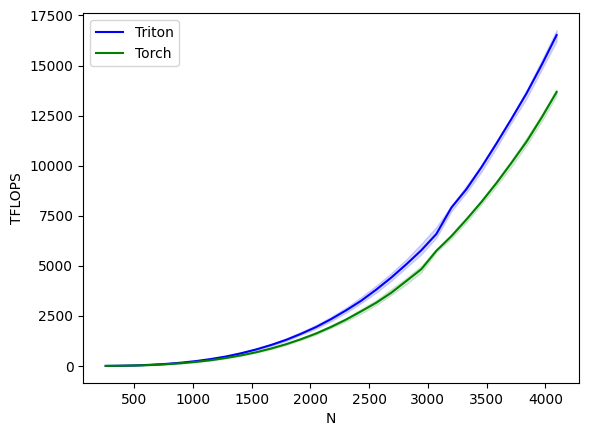

t_matmul:
         N       M       K        Triton         Torch
0    256.0   256.0   256.0      3.813004      3.172696
1    384.0   384.0   384.0     12.868887     10.691674
2    512.0   512.0   512.0     30.393507     25.305002
3    640.0   640.0   640.0     59.686704     49.275188
4    768.0   768.0   768.0    102.951099     85.662786
5    896.0   896.0   896.0    163.482532    136.649531
6   1024.0  1024.0  1024.0    243.148053    203.360188
7   1152.0  1152.0  1152.0    347.459958    287.805690
8   1280.0  1280.0  1280.0    473.184092    398.395134
9   1408.0  1408.0  1408.0    634.388483    528.657051
10  1536.0  1536.0  1536.0    823.608790    683.235057
11  1664.0  1664.0  1664.0   1047.146129    872.621744
12  1792.0  1792.0  1792.0   1303.121594   1086.590878
13  1920.0  1920.0  1920.0   1608.610918   1338.481034
14  2048.0  2048.0  2048.0   1945.184421   1621.966559
15  2176.0  2176.0  2176.0   2341.660871   1951.383990
16  2304.0  2304.0  2304.0   2779.679666   2319.914689


In [36]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N', 'M', 'K'],  # Argument names to use as an x-axis for the plot.
        x_vals=[128 * i for i in range(2, 33)],  # Different possible values for `x_name`.
        #x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='TFLOPS',  # Label name for the y-axis.
        plot_name='t_matmul',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
        # TODO T: Use real M i.e. 
    ))
def benchmark(N, M, K, provider):
    #dloss_dx = torch.rand(M, N, device="cuda", dtype=torch.float32)    
    #x = torch.rand(M, N, device="cuda", dtype=torch.float32)
    a = torch.rand(N, K, device="cuda", dtype=torch.float32)
    b = torch.rand(K, M, device="cuda", dtype=torch.float32)    
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_jit(x), quantiles=quantiles)
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_jit(dloss_dx, x), quantiles=quantiles)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_jit(aa, bb), quantiles=quantiles)
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_t(aa, bb), quantiles=quantiles)
    if provider == 'triton':
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_t(x), quantiles=quantiles)        
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_t(dloss_dx, x), quantiles=quantiles)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_t(aa, bb), quantiles=quantiles)
    #if provider == 'naive':
    #    #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_naive(x), quantiles=quantiles)
    #    ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_naive(dloss_dx, x), quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3) # TODO XXX: investigate whether this is right. In the tutorial they operate on different dtype
    return perf(ms), perf(max_ms), perf(min_ms)
benchmark.run(print_data=True, show_plots=True)

In [10]:
import torch
print(torch.cuda.get_device_properties("cuda"))
from triton.runtime import driver
device = torch.cuda.current_device()
properties = driver.active.utils.get_device_properties(device)
NUM_SM = properties["multiprocessor_count"]
SIZE_SMEM = properties["max_shared_mem"]
NUM_REGS = properties["max_num_regs"]
WARP_SIZE = properties["warpSize"] # Not 64 as A100
properties

_CudaDeviceProperties(name='NVIDIA A10G', major=8, minor=6, total_memory=22723MB, multi_processor_count=80, uuid=61ea3d2d-53a8-44f6-4844-0bcc29aa720b, L2_cache_size=6MB)


{'max_shared_mem': 101376,
 'max_num_regs': 65536,
 'multiprocessor_count': 80,
 'warpSize': 32,
 'sm_clock_rate': 1710000,
 'mem_clock_rate': 6251000,
 'mem_bus_width': 384}

In [12]:
num_stages = 4 if SIZE_SMEM > 200000 else 2
num_warps = 8
print(f'num_stages', num_stages, 'num_warps', num_warps)
x_2d = aa.reshape((-1, aa.shape[-1])) # TODO T: without this reshape, this func is 2times faster
n_rows, n_cols = x_2d.shape
BLOCK_SIZE = triton.next_power_of_2(n_cols) 
output = torch.empty_like(x_2d)

dloss_dx_2d = torch.randn_like(x_2d)
kernel = t_log_softmax_bkwd2_k.warmup(dloss_dx_2d, x_2d, output, dloss_dx_2d.stride(0), x_2d.stride(0), output.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE,
                                    num_stages=num_stages, num_warps=num_warps, grid=(1, ))
#kernel = t_log_softmax_fwd_k.warmup(x_2d, output, x_2d.stride(0), output.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE,
#                                   num_stages=num_stages, num_warps=num_warps, grid=(1, ))
kernel._init_handles()
n_regs = kernel.n_regs
size_smem = kernel.metadata.shared
print(f'n_regs', n_regs, 'size_smem', size_smem)

occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
print(f'occupancy', occupancy, SIZE_SMEM // size_smem)
occupancy = min(occupancy, SIZE_SMEM // size_smem)
num_programs = NUM_SM * occupancy
print(f'num_programs', num_programs)

num_stages 2 num_warps 8
n_regs 34 size_smem 4128
occupancy 7 24
num_programs 560


In [8]:
32
2080
4128
6176

6176